<a href="https://colab.research.google.com/github/leahmdmartins10/Phishing-Email-Detection-System-BERT/blob/main/ConfusionMatrixLR_July5th_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📧 Phishing Email Detection System Using BERT

In this project, we aim to build a phishing email detection model using deep learning techniques, with a focus on the BERT (Bidirectional Encoder Representations from Transformers) architecture.

Phishing emails are deceptive messages designed to trick users into revealing sensitive information. As attackers increasingly use AI to craft convincing emails, traditional rule-based filters fall short. This motivates the need for a more intelligent, language-aware detection system.

We begin by loading and preprocessing real-world phishing and legitimate email datasets. After tokenizing the data, we will train and evaluate a fine-tuned BERT model, and compare its performance to a logistic regression baseline. Our objective is to build a model that accurately classifies emails as "phishing" or "safe" using language patterns and contextual understanding.





In [ ]:
from google.colab import userdata
#KaggkeAPIKey = userdata.get('KaggleAPIKey')

---

# Mounting the google drive
We have to mount the google drive seeing as the files for the datasets are stored there

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


---
# Cleaning Data across Datasets
Making all data sets consistent in labeling, data type and format:

1. "body": Holds the body of all emails.
2. "urls": Holds the boolean value for if a url is present or not (1: url, 0: no url)
3. "label": Holds the boolen value for if an email is Phishing or Safe (1: phishing, 0 not phishing)


- REMOVING UNPARSABLE/ ILLEGAL DATA
- You can view all data at "APS360_Final_Cleaned_Data" in shared folder

In [ ]:
!pip install xlsxwriter
!pip install pandas openpyxl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.3/172.3 kB 3.1 MB/s eta 0:00:00


In [ ]:
import os
import pandas as pd
import re

#Folder with your CSVs
source_folder = '/content/drive/MyDrive/APS360 Notes/Datasets'
output_excel_path = os.path.join(source_folder, 'APS360_Final_Cleaned_Data.xlsx')

#Patterns to detect illegal Excel characters and ANSI sequences
ansi_pattern = re.compile(r'[\x1B\x1b]\[[0-9;]*[A-Za-z]|[0-9]+;[0-9]+[Hf]')
illegal_excel_chars = re.compile(r"[\x00-\x08\x0B-\x1F]")

#Function to check if a row contains illegal characters
def row_has_illegal_data(row):
    return any(
        ansi_pattern.search(str(cell)) or illegal_excel_chars.search(str(cell))
        for cell in row
    )

#Create ExcelWriter object
with pd.ExcelWriter(output_excel_path, engine='openpyxl') as writer:
    for filename in os.listdir(source_folder):
        if filename.endswith('.csv'):
            filepath = os.path.join(source_folder, filename)

            try:
                df = pd.read_csv(filepath, on_bad_lines='skip', encoding='utf-8', engine='python')
            except Exception as e:
                print(f"Skipping {filename} due to read error: {e}")
                continue

            #Drop rows with illegal characters
            df = df[~df.apply(row_has_illegal_data, axis=1)]

            #Clean and rename columns
            df.columns = [col.strip() for col in df.columns]
            col_map = {}
            for col in df.columns:
                if col.lower() in ['email text', 'text']:
                    col_map[col] = 'body'
                elif col.lower() == 'email type':
                    col_map[col] = 'label'
            df = df.rename(columns=col_map)

            #Add 'urls' column if missing
            if 'urls' not in df.columns and 'body' in df.columns:
                df['urls'] = df['body'].astype(str).apply(lambda x: 1 if 'http' in x else 0)

            #Keep only ['body', 'urls', 'label']
            keep_cols = [col for col in ['body', 'urls', 'label'] if col in df.columns]
            df = df[keep_cols]

            #Write sheet to Excel
            sheet_name = os.path.splitext(filename)[0][:31]
            try:
                df.to_excel(writer, sheet_name=sheet_name, index=False)
            except Exception as e:
                print(f"Failed to write sheet for {filename}: {e}")

print(f"Done! Cleaned Excel file saved at:\n{output_excel_path}")

Done! Cleaned Excel file saved at:
/content/drive/MyDrive/APS360 Notes/Datasets/APS360_Final_Cleaned_Data.xlsx


---
#Combine Data into One Large Dataset

- Takes all csv files and merges into one giant data set.
- Removes empty and null rows.
- Randomly shuffles and rearranges data.
- Makes sure that "label" and "urls" data is numerical later processing

In [ ]:
#This is a function Force string/int labels to integer 0 or 1
#Will be used later in combination (for cleaning purposes)

def clean_numerics(x):
    x_str = str(x).strip().lower()
    if x_str in ['1', 'phishing email']:
        return 1
    elif x_str in ['0', 'safe email']:
        return 0
    else:
        return 0

In [ ]:
#Load all sheets
all_sheets = pd.read_excel(output_excel_path, sheet_name=None)

#Concatenate all sheets into one DataFrame
phishing_df = pd.concat(all_sheets.values(), ignore_index=True)

#Drop rows with missing values (if any)
phishing_df = phishing_df.dropna()

#Shuffle dataset
phishing_df = phishing_df.sample(frac=1, random_state=42).reset_index(drop=True)

#Checks that this data is numerical
phishing_df['label'] = phishing_df['label'].apply(clean_numerics)
phishing_df['urls'] = phishing_df['urls'].apply(clean_numerics)


---
#Split Tensor Data into Training Validation and Testing Datasets

- Randomly split the encoded email data into 70% training, 15% validation, and 15% test sets.
- Each split contains input tensors from the tokenization (input_ids, attention_mask) along with corresponding labels and URL indicators (from phishing_df ).
- This prepares the data for use in training and evaluating an AI classification model.




In [ ]:
from sklearn.model_selection import train_test_split
import torch

#Convert labels and urls to tensors
label = torch.tensor(phishing_df['label'].values)
urls = torch.tensor(phishing_df['urls'].values)

#First split into training data for 70% and temp data (vaidation + testing) for 30%
train_idx, temp_idx = train_test_split(range(len(label)), test_size=0.3, random_state=42)

#Then split temp into validation and testing 15% each
val_idx, test_idx = train_test_split(temp_idx, test_size=0.5, random_state=42)


In [ ]:
# splitting the bodies for train, val, and test data
train_bodies = phishing_df['body'][train_idx].tolist()
val_bodies = phishing_df['body'][val_idx].tolist()
test_bodies = phishing_df['body'][test_idx].tolist()

# converting the training, val, and test urls and labels to tensors
train_urls = torch.tensor(phishing_df['urls'][train_idx].tolist())
train_labels = torch.tensor(phishing_df['label'][train_idx].tolist())


val_urls = torch.tensor(phishing_df['urls'][val_idx].tolist())
val_labels = torch.tensor(phishing_df['label'][val_idx].tolist())


test_urls = torch.tensor(phishing_df['urls'][test_idx].tolist())
test_labels = torch.tensor(phishing_df['label'][test_idx].tolist())

---
# **Tokenize the training, validation, and testing bodies**
We are now tokenizing the data that we have previously split. This tokenizing code has been repurposed from Asmita's code.

In [ ]:

from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

class PhishingEmailDataset(Dataset):
    def __init__(self, texts, urls, labels, tokenizer, max_length=256):
        self.texts = texts
        self.urls = urls
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'urls': self.urls[idx],
            'labels': self.labels[idx]
        }

#Create datasets
train_dataset = PhishingEmailDataset(train_bodies, train_urls, train_labels, tokenizer)
val_dataset = PhishingEmailDataset(val_bodies, val_urls, val_labels, tokenizer)
test_dataset = PhishingEmailDataset(test_bodies, test_urls, test_labels, tokenizer)

#Create DataLoaders
batch_size = 8

train_loader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=batch_size)
val_loader = DataLoader(val_dataset, sampler=SequentialSampler(val_dataset), batch_size=batch_size)
test_loader = DataLoader(test_dataset, sampler=SequentialSampler(test_dataset), batch_size=batch_size)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

---
# **Converting the Tokenized Data to Complete Tensors**


# Tokenization for Logisitic Regression

This implementation of tokenization will be used specifically for the logistic regression model. The implementation steps include:
  1. Vectorizing the sentences
  2. Counting the occurances of words
  3. Vectorizing the numbers for the corresponding words

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(ngram_range=(1,3))

train_bow = vectorizer.fit_transform(train_bodies)
val_bow = vectorizer.transform(val_bodies)
test_bow = vectorizer.transform(test_bodies)

---
#**Apply Pretrained BERT Model**

- Initialize Pretrained BERT Model Transformer
- Use AdamW Optimizer for optimization and loss
- Define Dataloaders from tensors
- Train the Model

In [ ]:
"""Initialize Pretrained BERT Model Transformer"""

from transformers import BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=2  # Binary classification
)


import torch

# Set up device (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Move model to device
model = model.to(device)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using device: cpu


In [ ]:
"""Use AdamW Optimizer for optimization and loss"""
from torch.optim import AdamW
optimizer = AdamW(model.parameters(), lr=2e-5)


In [ ]:
epochs = 3

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in train_loader:
        b_input_ids = batch['input_ids'].to(device)
        b_attention_mask = batch['attention_mask'].to(device)
        b_labels = batch['labels'].to(device)
        b_urls = batch['urls']

        model.zero_grad()

        outputs = model(
            input_ids=b_input_ids,
            attention_mask=b_attention_mask,
            labels=b_labels
        )

        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch + 1} completed. Avg loss: {avg_loss:.4f}")


KeyboardInterrupt: 

# Cleaning up RAM usage **(Place this block at the bottom of the code for now please)**
We are going to clean up some data to prevent high usage of memory. Please note, you can only run this cell once if you don't reinstantiate these variables

In [ ]:
import gc

del phishing_df

del train_bodies, val_bodies, test_bodies

del tokenizedTraining, tokenizedValidation, tokenizedTest

gc.collect()

NameError: name 'tokenizedTraining' is not defined

**Binary Logistic Regression - Baseline Model**

[[4390  132]
 [  43 5504]]
Accuracy: 0.9826199225345119


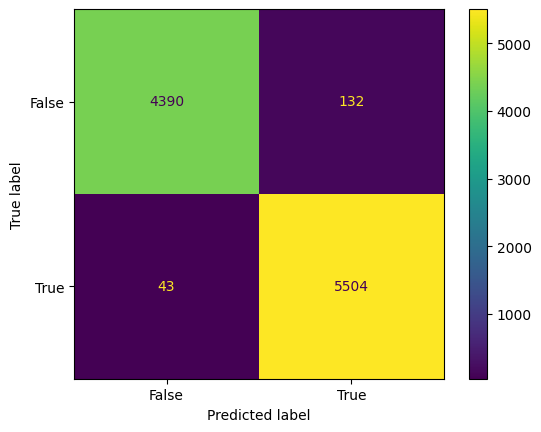

Precision: 0.9765791341376863
Recall: 0.9922480620155039
F1 Score: 0.9843512474291335


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

baselineModel = LogisticRegression(max_iter=1000, random_state=0)

baselineModel.fit(train_bow, train_labels) #train the model

prediction = baselineModel.predict(test_bow) #predict class labels for samples in test dataset

#compute confusion matrix
confusionMatrix = confusion_matrix(test_labels, prediction)
print(confusionMatrix)

#compute accuracy
accuracy = (confusionMatrix[1][1] + confusionMatrix[0][0])/(confusionMatrix[1][1] + confusionMatrix[0][0] + confusionMatrix[0][1] + confusionMatrix[1][0])
print(f"Accuracy: {accuracy}")

#plot confusion matrix representation
display = ConfusionMatrixDisplay(confusion_matrix = confusionMatrix, display_labels=[False, True])
display.plot()
plt.show()

#compute precision
precision = confusionMatrix[1][1]/(confusionMatrix[1][1] + confusionMatrix[0][1])
print(f"Precision: {precision}")

#compute recall
recall = confusionMatrix[1][1]/(confusionMatrix[1][1] + confusionMatrix[1][0])
print(f"Recall: {recall}")

#compute F1 score
f1 = 2*(precision*recall)/(precision + recall)
print(f"F1 Score: {f1}")


